In [1]:
from __future__ import division
import pandas as pd
import math
from gensim.models import coherencemodel
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 
import random
import ast
import html
import re
from sklearn.decomposition import TruncatedSVD

from tqdm import tqdm
#np.set_printoptions(threshold=np.inf) #set to print full output
import numpy as np
random.seed(42)
#os.chdir('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline')
import sys
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoTokenizer, AutoModel  # Import AutoTokenizer and AutoModel
import nltk
import matplotlib.pyplot as plt
#sys.path.append('/home/ll16598/Documents/Altered_States_Reddit/model_pipeline/__pycache__')
#from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

2025-04-11 17:20:00.229578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 17:20:00.784292: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 17:20:00.787700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 17:20:03.092836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
meta_dir='/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/metanalysis_results/'
meta_files=os.listdir(meta_dir)

In [3]:
def get_p_code(p):
    if p<=0.10 and p>0.05:
        code=  '.'
    elif p<=0.05 and p>0.01:
        code= '*'
    elif p<=0.01 and p>0.001:
        code= '**'
    elif p<=0.001:
        code= '***'
    else:
        code=''
    return code

In [4]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_forest(ax, data, title, show_X=False):
    """
    Creates a forest plot using the given axes (ax), with diamond-shaped markers and magma colormap.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        data (pd.DataFrame): Data containing study names, effect sizes, CIs, and weights.
    """
    y_positions = np.arange(len(data))[::-1]  # Reverse order for correct plotting
    marker_sizes = data["weight"] / max(data["weight"]) * 100  # Scale marker sizes
    
    # Normalize effect sizes for color mapping
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    cmap = cm.magma  # Use the magma colormap

    # Plot confidence intervals (whiskers)
    for i in range(len(data)):
        color = cmap(norm(data["yi"][i]))  # Get color based on effect size
        ax.hlines(y_positions[i], data["ci.lb"][i], data["ci.ub"][i], color='black', lw=2)

    # Plot diamond-shaped effect size points
    scatter = ax.scatter(data["yi"], y_positions, s=marker_sizes, c=data["yi"], cmap="magma",
                         marker="D", edgecolor="black", linewidth=1, norm=norm,zorder=3)

    # Highlight the overall effect size with a larger diamond
    overall_idx = data.index[-1]  # Last row is the overall effect
    ax.scatter(data["yi"][overall_idx], y_positions[overall_idx], s=marker_sizes[overall_idx],
               color=cmap(norm(data["yi"][overall_idx])), marker="D",
               edgecolor="black", linewidth=1.5, zorder=4, label="Overall Effect")

    # Vertical line at zero (null effect)
    ax.axvline(0, color='gray', linestyle='dashed', linewidth=1)
    P = data["p_val"].iloc[0]  # Use iloc[0] to ensure it's the first value
    stars=get_p_code(P)
    p_str = f"p={P:.3f}{stars}"
    p_str_bold = r"$\bf{" + p_str + "}$"
    if P<0.05:
        ax.set_title(f'{title}\n{p_str_bold}', fontsize=10)
    else:
        ax.set_title(f'{title}\n{p_str}', fontsize=10)
    # Set labels
    ax.set_yticks(y_positions)
    ax.set_xticks(np.arange(-1.2,0.61,0.4))
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=10)

    xmin, xmax = ax.get_xlim()
    bound = max(abs(xmin), abs(xmax))
    ax.set_xlim(-bound, 0.61)
    ax.set_yticklabels(data["Study"])
    if show_X:
        ax.set_xlabel("Effect Size")
    else:
        ax.set_xlabel("")
    # Adjust layout
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [5]:
dir_save_figs='/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/plots/'
save=True

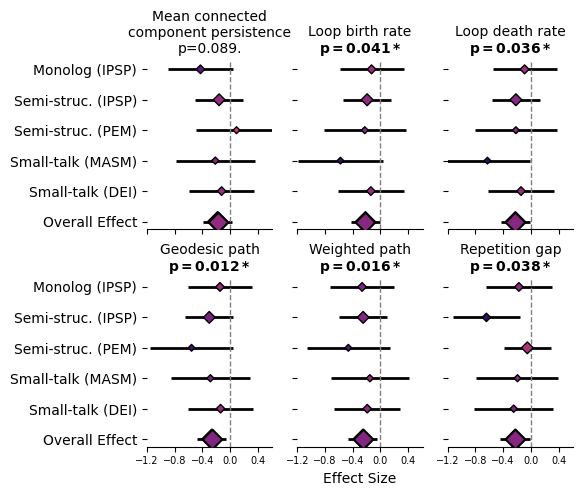

In [6]:
# Example usage:

span=1
props=['mean_persistence_dim0','birth_rate_dim1', 'death_rate_dim1','shortest_path_unweighted'\
      , 'shortest_path_weighted','avg_gap']
titles=['Mean connected\ncomponent persistence','Loop birth rate','Loop death rate','Geodesic path','Weighted path','Repetition gap']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5.5, 5), sharex=True, sharey=True)
axes = axes.flat  
for i, (prop, ax) in enumerate(zip(props, axes)):
    
    if prop in ['avg_gap']:
        data = pd.read_csv(meta_dir + f'{prop}syntax_forest_plot_data.csv')  # Load dataset
    else:    
        data = pd.read_csv(meta_dir + f'{prop}_{span}utt_forest_plot_data.csv')  # Load dataset
    main_effect=list(data['yi'])[-1]
    data["Study"] = data["Study"].replace({
    "SER_monologs": "Monolog (IPSP)",
    "SER_IPSP": "Semi-struc. (IPSP)",
    "PEM_df": "Semi-struc. (PEM)",
    "MASM": "Small-talk (MASM)",
    "cleaned_DEI": "Small-talk (DEI)",
    "Overall (Random-Effects)": f"Overall Effect"
})
    if i in [0,1,2,3,5]:
        show_x=False
    else:
        show_x=True
    title=titles[i] 
    #{main_effect:.2f}
    plot_forest(ax, data, title, show_X=show_x)  # Plot on respective panel
#axes[-1].axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.3)

if save:
    plt.savefig(dir_save_figs+'utterance_meta.png', dpi=800, bbox_inches='tight')

plt.show()

In [26]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_forest(ax, data, title, show_X=False):
    """
    Creates a forest plot using the given axes (ax), with diamond-shaped markers and magma colormap.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        data (pd.DataFrame): Data containing study names, effect sizes, CIs, and weights.
    """
    y_positions = np.arange(len(data))[::-1]  # Reverse order for correct plotting
    marker_sizes = data["weight"] / max(data["weight"]) * 100  # Scale marker sizes
    
    # Normalize effect sizes for color mapping
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    cmap = cm.magma  # Use the magma colormap

    # Plot confidence intervals (whiskers)
    for i in range(len(data)):
        color = cmap(norm(data["yi"][i]))  # Get color based on effect size
        ax.hlines(y_positions[i], data["ci.lb"][i], data["ci.ub"][i], color='black', lw=2)

    # Plot diamond-shaped effect size points
    scatter = ax.scatter(data["yi"], y_positions, s=marker_sizes, c=data["yi"], cmap="magma",
                         marker="D", edgecolor="black", linewidth=1, norm=norm,zorder=3)

    # Highlight the overall effect size with a larger diamond
    overall_idx = data.index[-1]  # Last row is the overall effect
    ax.scatter(data["yi"][overall_idx], y_positions[overall_idx], s=marker_sizes[overall_idx],
               color=cmap(norm(data["yi"][overall_idx])), marker="D",
               edgecolor="black", linewidth=1.5, zorder=4, label="Overall Effect")

    # Vertical line at zero (null effect)
    ax.axvline(0, color='gray', linestyle='dashed', linewidth=1)
    P = data["p_val"].iloc[0]  # Use iloc[0] to ensure it's the first value
    stars=get_p_code(P)
    p_str = f"p={P:.3f}{stars}"
    p_str_bold = r"$\bf{" + p_str + "}$"
    if P<0.05:
        ax.set_title(f'{title}\n{p_str_bold}', fontsize=10)
    else:
        ax.set_title(f'{title}\n{p_str}', fontsize=10)
    # Set labels
    ax.set_yticks(y_positions)
    xmin, xmax = ax.get_xlim()
    bound = max(abs(xmin), abs(xmax))
    ax.set_xticks(np.arange(-1.2,1.21,0.4))
    ax.set_xlim(-bound, 1.21)

    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=10)

    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_yticklabels(data["Study"])
    if show_X:
        ax.set_xlabel("Effect Size")
    else:
        ax.set_xlabel("")
    # Adjust layout



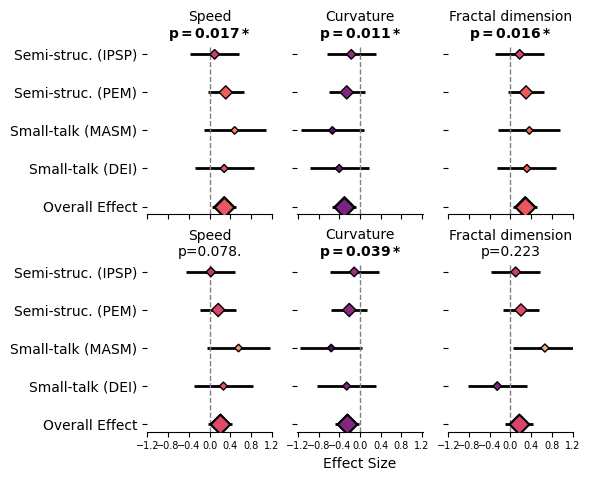

In [43]:
# Example usage:

props=['semantic_speed','mean_curvature', 'fractal_dimension']
titles=['Speed','Curvature','Fractal dimension']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(5.5, 5), sharex=True, sharey=True)
axes = axes.flat  

for s, span in enumerate([80,40]):
    for i, prop in enumerate(props):
        if s==1:
            ax_id=i+3
        else:
            ax_id=i
        ax=axes[ax_id]
        data = pd.read_csv(meta_dir + f'{prop}_{span}_forest_plot_data.csv')  # Load dataset
        main_effect=list(data['yi'])[-1]
        data["Study"] = data["Study"].replace({
    #    "SER_monologs": "Monolog (IPSP)",
        "SER_IPSP": "Semi-struc. (IPSP)",
        "PEM_df": "Semi-struc. (PEM)",
        "MASM": "Small-talk (MASM)",
        "cleaned_DEI": "Small-talk (DEI)",
        "Overall (Random-Effects)": f"Overall Effect"
    })
        if ax_id==4:
            show_x=True
        else:
            show_x=False
        title=titles[i] 
        #{main_effect:.2f}
        plot_forest(ax, data, title, show_X=show_x)  # Plot on respective panel
    #axes[-1].axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

if save:
    plt.savefig(dir_save_figs+'FLOW_meta.png', dpi=800, bbox_inches='tight')

plt.show()

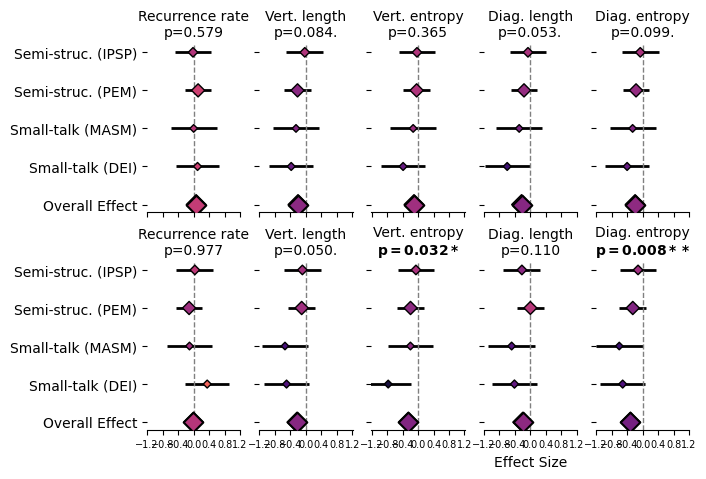

In [47]:
# Example usage:

span=1
props=['recurrence_rate', 'V','Ventr','L','Lentr']
titles=['Recurrence rate','Vert. length','Vert. entropy' ,'Diag. length','Diag. entropy']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(7, 5), sharex=True, sharey=True)
axes = axes.flat  

for s, span in enumerate([80,40]):
    for i, prop in enumerate(props):
        if s==1:
            ax_id=i+len(props)
        else:
            ax_id=i
        ax=axes[ax_id]
        data = pd.read_csv(meta_dir + f'{prop}_{span}_forest_plot_data.csv')  # Load dataset
        main_effect=list(data['yi'])[-1]
        data["Study"] = data["Study"].replace({
    #    "SER_monologs": "Monolog (IPSP)",
        "SER_IPSP": "Semi-struc. (IPSP)",
        "PEM_df": "Semi-struc. (PEM)",
        "MASM": "Small-talk (MASM)",
        "cleaned_DEI": "Small-talk (DEI)",
        "Overall (Random-Effects)": f"Overall Effect"
    })
        if ax_id==8:
            show_x=True
        else:
            show_x=False
        title=titles[i] 
        #{main_effect:.2f}
        plot_forest(ax, data, title, show_X=show_x)  # Plot on respective panel
    #axes[-1].axis('off')
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

if save:
    plt.savefig(dir_save_figs+'RQA_meta.png', dpi=800, bbox_inches='tight')

plt.show()

In [8]:
dim_reduction=75
analysis='trajectory'
dir_small_talk_ps=f'/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/stats_results/{analysis}_{dim_reduction}_small_talk_p_values.csv'
small_p_df=pd.read_csv(dir_small_talk_ps)

In [31]:
dir_small_talk_ps2=f'/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/stats_results/{analysis}_{dim_reduction}_small_talk_p_values2.csv'
small_p_df2=pd.read_csv(dir_small_talk_ps2)

In [26]:
small_p_df=small_p_df[small_p_df['span']<80].reset_index(drop=True)

In [32]:
# vars_to_plot=['death_rate_dim0', 'mean_persistence_dim0',
#                     'max_persistence_dim0', 'std_persistence_dim0', 'skewness_dim0',
#                     'kurtosis_dim0', 'entropy_dim0', 'number_dim0',
#                     'birth_rate_dim1',
#                     'death_rate_dim1',
#                     'mean_persistence_dim1', 'max_persistence_dim1',
#                     'std_persistence_dim1', 'skewness_dim1', 'kurtosis_dim1',
#                     'entropy_dim1', 'number_dim1',
#              'fiedler_value']
# small_p_df=small_p_df[small_p_df['variable'].isin(vars_to_plot)].reset_index(drop=True)

In [33]:
small_p_df2

,span,variable,anova_p_value,tukey_MDMAvsMA20,tukey_PL_vs_MA20,tukey_PL_vs_MDMA20,tukey_MDMAvsMA40,tukey_PL_vs_MA40,tukey_PL_vs_MDMA40,tukey_MDMAvsMA60,tukey_PL_vs_MA60,tukey_PL_vs_MDMA60,e_MDMAvsMA,e_PL_vs_MA,e_PL_vs_MDMA
0,20,trajectory_length,0.184850,0.168296,0.763579,0.389874,0.168296,0.763579,0.389874,0.168296,0.763579,0.389874,0.390182,0.135346,-0.254836
1,20,semantic_speed,0.031594,0.989534,0.058979,0.087704,0.989534,0.058979,0.087704,0.989534,0.058979,0.087704,0.027599,0.412766,0.385167
2,20,semantic_acceleration,0.115761,0.888698,0.314219,0.126217,0.888698,0.314219,0.126217,0.888698,0.314219,0.126217,-0.088485,0.253007,0.341491
3,20,mean_curvature,0.022794,0.978497,0.076192,0.045683,0.978497,0.076192,0.045683,0.978497,0.076192,0.045683,0.033689,-0.328304,-0.361993
4,20,recurrence_rate,0.031455,0.086363,0.146070,0.887456,0.097297,0.162533,0.887421,0.103317,0.186036,0.870092,-0.408495,-0.414144,-0.423582
5,20,fractal_dimension,0.197694,0.999652,0.296337,0.287713,0.999652,0.296337,0.287713,0.999652,0.296337,0.287713,-0.004417,0.234383,0.238800
6,20,RR,0.214681,0.189595,0.718995,0.479874,0.189595,0.718995,0.479874,0.189595,0.718995,0.479874,-0.339604,-0.135694,0.203909
7,20,DET,0.004816,0.976101,0.023021,0.012420,0.976101,0.023021,0.012420,0.976101,0.023021,0.012420,0.033936,-0.390212,-0.424148
8,20,L,0.004344,0.644983,0.072877,0.004653,0.644983,0.072877,0.004653,0.644983,0.072877,0.004653,0.148870,-0.333757,-0.482627
9,20,Lmax,0.347782,0.507081,0.982125,0.342258,0.507081,0.982125,0.342258,0.507081,0.982125,0.342258,0.168645,-0.024875,-0.193520


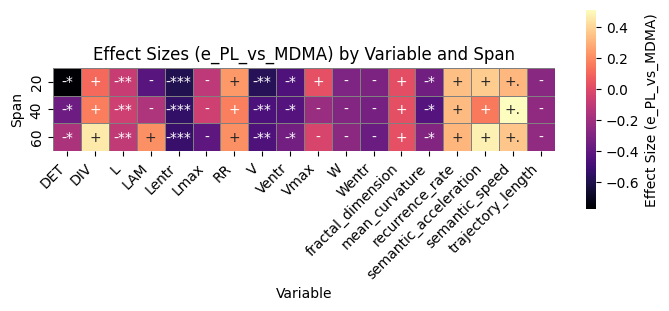

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure span is sorted for plotting consistency
small_p_df = small_p_df.sort_values(by='span')

# Create pivot tables
effect_matrix = small_p_df.pivot(index='span', columns='variable', values='e_PL_vs_MDMA')
pval_matrix = small_p_df.pivot(index='span', columns='variable', values='tukey_PL_vs_MDMA')

# Create annotation matrix: sign (+/-) + significance (*)
def annotate_cell(effect, pval):
    if pd.isna(effect) or pd.isna(pval):
        return ''
    sign = '+' if effect > 0 else '-'
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    elif pval < 0.1:
        stars = '.'
    else:
        stars = ''
    return f"{sign}{stars}"

annotations = effect_matrix.copy()
# for i in effect_matrix.index:
#     for j in effect_matrix.columns:
#         annotations.loc[i, j] = annotate_cell(effect_matrix.loc[i, j], pval_matrix.loc[i, j])
for span in effect_matrix.index:
    span_col = f'tukey_PL_vs_MDMA{span}'  # Correct span-specific column
    for variable in effect_matrix.columns:
        pval_row = small_p_df2[small_p_df2['variable'] == variable]
        if not pval_row.empty:
            pval = pval_row.iloc[0][span_col]
            annotations.loc[span, variable] = annotate_cell(effect_matrix.loc[span, variable], pval)

# Convert effect_matrix to float to avoid issues in heatmap
effect_matrix = effect_matrix.astype(float)

# --- Your existing heatmap setup ---
plt.figure(figsize=(7, 3))
ax = sns.heatmap(effect_matrix, 
                 annot=annotations, 
                 fmt='', 
                 cmap='magma', 
                 cbar_kws={'label': 'Effect Size (e_PL_vs_MDMA)'}, 
                 linewidths=0.5, 
                 linecolor='gray', 
                 square=True)

# --- Get column labels and add significance markers ---
col_labels = effect_matrix.columns.tolist()
#overall_sig=pd.Series(list(small_p_df2[['tukey_PL_vs_MDMA']]['tukey_PL_vs_MDMA']), index=col_labels)

def get_sig_code(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

# Apply significance codes
#sig_labels = [f"{get_sig_code(overall_sig[col])} {col}" for col in col_labels]
sig_labels = [f"{col}" for col in col_labels]

# Set new x-axis tick labels with significance
ax.set_xticklabels(sig_labels, rotation=45, ha='right')

# --- Final touches ---
plt.title('Effect Sizes (e_PL_vs_MDMA) by Variable and Span')
plt.ylabel('Span')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()



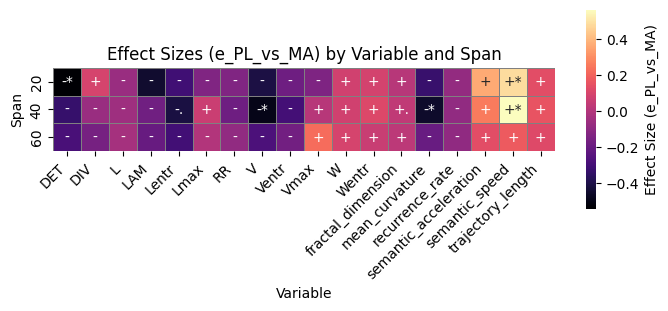

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure span is sorted for plotting consistency
small_p_df = small_p_df.sort_values(by='span')

# Create pivot tables
effect_matrix = small_p_df.pivot(index='span', columns='variable', values='e_PL_vs_MA')
pval_matrix = small_p_df.pivot(index='span', columns='variable', values='tukey_PL_vs_MA')

# Create annotation matrix: sign (+/-) + significance (*)
def annotate_cell(effect, pval):
    if pd.isna(effect) or pd.isna(pval):
        return ''
    sign = '+' if effect > 0 else '-'
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    elif pval < 0.1:
        stars = '.'
    else:
        stars = ''
    return f"{sign}{stars}"

annotations = effect_matrix.copy()
for i in effect_matrix.index:
    for j in effect_matrix.columns:
        annotations.loc[i, j] = annotate_cell(effect_matrix.loc[i, j], pval_matrix.loc[i, j])

# Convert effect_matrix to float to avoid issues in heatmap
effect_matrix = effect_matrix.astype(float)

# --- Your existing heatmap setup ---
plt.figure(figsize=(7, 3))
ax = sns.heatmap(effect_matrix, 
                 annot=annotations, 
                 fmt='', 
                 cmap='magma', 
                 cbar_kws={'label': 'Effect Size (e_PL_vs_MA)'}, 
                 linewidths=0.5, 
                 linecolor='gray', 
                 square=True)

# --- Get column labels and add significance markers ---
col_labels = effect_matrix.columns.tolist()
#overall_sig=pd.Series(list(small_p_df2[['tukey_PL_vs_MA']]['tukey_PL_vs_MA']), index=col_labels)

def get_sig_code(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

# Apply significance codes
#sig_labels = [f"{get_sig_code(overall_sig[col])} {col}" for col in col_labels]
sig_labels = [f"{col}" for col in col_labels]

# Set new x-axis tick labels with significance
ax.set_xticklabels(sig_labels, rotation=45, ha='right')

# --- Final touches ---
plt.title('Effect Sizes (e_PL_vs_MA) by Variable and Span')
plt.ylabel('Span')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()



In [19]:
dir_SER_ps='/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/stats_results/SERMA_combined_p_values.csv'
ser_p_df=pd.read_csv(dir_SER_ps)

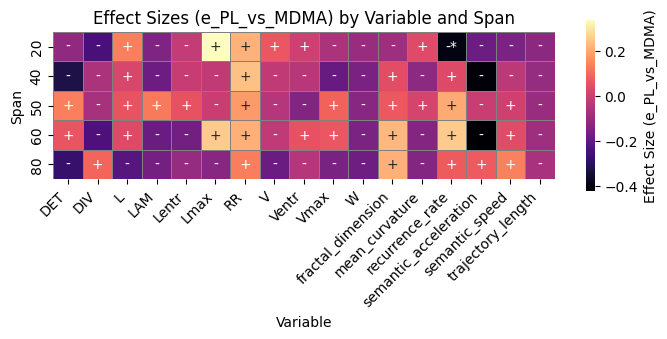

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure span is sorted for plotting consistency
ser_p_df = ser_p_df.sort_values(by='span')

# Create pivot tables
effect_matrix = ser_p_df.pivot(index='span', columns='variable', values='e_PL_vs_MDMA')
pval_matrix = ser_p_df.pivot(index='span', columns='variable', values='tukey_PL_vs_MDMA')

# Create annotation matrix: sign (+/-) + significance (*)
def annotate_cell(effect, pval):
    if pd.isna(effect) or pd.isna(pval):
        return ''
    sign = '+' if effect > 0 else '-'
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    elif pval < 0.1:
        stars = '.'
    else:
        stars = ''
    return f"{sign}{stars}"

annotations = effect_matrix.copy()
for i in effect_matrix.index:
    for j in effect_matrix.columns:
        annotations.loc[i, j] = annotate_cell(effect_matrix.loc[i, j], pval_matrix.loc[i, j])

# Convert effect_matrix to float to avoid issues in heatmap
effect_matrix = effect_matrix.astype(float)

# --- Your existing heatmap setup ---
plt.figure(figsize=(7, 3))
ax = sns.heatmap(effect_matrix, 
                 annot=annotations, 
                 fmt='', 
                 cmap='magma', 
                 cbar_kws={'label': 'Effect Size (e_PL_vs_MDMA)'}, 
                 linewidths=0.5, 
                 linecolor='gray', 
                 square=True)

# --- Get column labels and add significance markers ---
col_labels = effect_matrix.columns.tolist()
#overall_sig=pd.Series(list(small_p_df2[['tukey_PL_vs_MDMA']]['tukey_PL_vs_MDMA']), index=col_labels)

def get_sig_code(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

# Apply significance codes
sig_labels = [f"{col}" for col in col_labels]

# Set new x-axis tick labels with significance
ax.set_xticklabels(sig_labels, rotation=45, ha='right')

# --- Final touches ---
plt.title('Effect Sizes (e_PL_vs_MDMA) by Variable and Span')
plt.ylabel('Span')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()



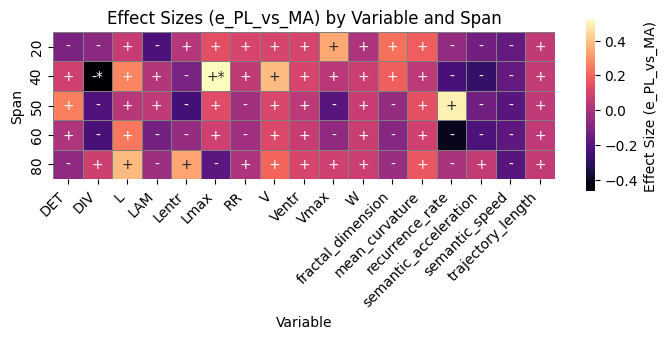

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure span is sorted for plotting consistency
ser_p_df = ser_p_df.sort_values(by='span')

# Create pivot tables
effect_matrix = ser_p_df.pivot(index='span', columns='variable', values='e_PL_vs_MA')
pval_matrix = ser_p_df.pivot(index='span', columns='variable', values='tukey_PL_vs_MA')

# Create annotation matrix: sign (+/-) + significance (*)
def annotate_cell(effect, pval):
    if pd.isna(effect) or pd.isna(pval):
        return ''
    sign = '+' if effect > 0 else '-'
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    elif pval < 0.1:
        stars = '.'
    else:
        stars = ''
    return f"{sign}{stars}"

annotations = effect_matrix.copy()
for i in effect_matrix.index:
    for j in effect_matrix.columns:
        annotations.loc[i, j] = annotate_cell(effect_matrix.loc[i, j], pval_matrix.loc[i, j])

# Convert effect_matrix to float to avoid issues in heatmap
effect_matrix = effect_matrix.astype(float)

# --- Your existing heatmap setup ---
plt.figure(figsize=(7, 3))
ax = sns.heatmap(effect_matrix, 
                 annot=annotations, 
                 fmt='', 
                 cmap='magma', 
                 cbar_kws={'label': 'Effect Size (e_PL_vs_MA)'}, 
                 linewidths=0.5, 
                 linecolor='gray', 
                 square=True)

# --- Get column labels and add significance markers ---
col_labels = effect_matrix.columns.tolist()
#overall_sig=pd.Series(list(small_p_df2[['tukey_PL_vs_MDMA']]['tukey_PL_vs_MDMA']), index=col_labels)

def get_sig_code(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

# Apply significance codes
sig_labels = [f"{col}" for col in col_labels]

# Set new x-axis tick labels with significance
ax.set_xticklabels(sig_labels, rotation=45, ha='right')

# --- Final touches ---
plt.title('Effect Sizes (e_PL_vs_MA) by Variable and Span')
plt.ylabel('Span')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()



In [38]:
import pandas as pd
import numpy as np

# Define the list of variables
variable_list = ['L','Lentr','V','Ventr','LAM']

# Set working directory (adjust as needed)
working_dir = "/home/ll16598/Documents/POSTDOC/trajectory_output/"

def z_norm(df, var):
    """
    Adds 1 to the given variable, then normalizes it using the mean and standard deviation
    computed over rows where Drug=='PL'. New columns 'centered_var' and 'z_score' are added.
    """
    df = df.copy()
    df[var] = df[var] + 1
    # Select rows where Drug is 'PL' and the variable is not missing
    df_placebo = df[(df['Drug'] == 'PL') & (df[var].notna())]
    mean_placebo = df_placebo[var].mean()
    std_placebo = df_placebo[var].std()
    df['centered_var'] = df[var] - mean_placebo
    df['z_score'] = df['centered_var'] / std_placebo
    return df

# Loop over span values
span=40
dim_reduction=100

def create_small_talk_data(var,analysis='trajectory', span=40, dim_reduction=50):
    # Construct CSV filenames based on span and other parameters
    csv_file1 = f"{working_dir}MASM_{span}_{dim_reduction}_utterance_trajectory_results.csv"
    csv_file2 = f"{working_dir}cleaned_DEI_{span}_{dim_reduction}_utterance_trajectory_results.csv"

    # If analysis equals 'TDA', use alternative filenames
    if analysis == 'TDA':
        csv_file1 = f"{working_dir}MASM_{span}_mean_{dim_reduction}_window_{analysis}_results.csv"
        csv_file2 = f"{working_dir}cleaned_DEI_{span}_mean_{dim_reduction}_window_{analysis}_results.csv"

    # Read the CSV files into DataFrames
    df_with_tda1 = pd.read_csv(csv_file1)
    df_with_tda2 = pd.read_csv(csv_file2)

    # Recode the Drug column based on the condition column
    df_with_tda1['Drug'] = df_with_tda1['condition']
    df_with_tda1.loc[df_with_tda1['Drug'] == "['PLC']", 'Drug'] = "PL"
    df_with_tda1.loc[df_with_tda1['Drug'] == "['MDMA']", 'Drug'] = "MDMA"
    df_with_tda1.loc[df_with_tda1['Drug'] == "['MA']", 'Drug'] = "MA"

    df_with_tda2['Drug'] = df_with_tda2['condition']
    df_with_tda2.loc[df_with_tda2['Drug'] == "['PLC.txt']", 'Drug'] = "PL"
    df_with_tda2.loc[df_with_tda2['Drug'] == "['MDMA.txt']", 'Drug'] = "MDMA"
    df_with_tda2.loc[df_with_tda2['Drug'] == "['MA.txt']", 'Drug'] = "MA"

    # Add study labels
    df_with_tda1['study'] = 'MASM'
    df_with_tda2['study'] = 'DEI'

    # Get common columns between the two DataFrames and subset them
    common_cols = df_with_tda1.columns.intersection(df_with_tda2.columns)
    df_with_tda1 = df_with_tda1[common_cols]
    df_with_tda2 = df_with_tda2[common_cols]
    df_with_tda1 = z_norm(df_with_tda1, var)  # Normalize variable in df_with_tda1
    df_with_tda2 = z_norm(df_with_tda2, var)  # Normalize variable in df_with_tda2

    # Combine the two DataFrames by stacking the rows
    df_with_tda = pd.concat([df_with_tda1, df_with_tda2], ignore_index=True)

    # Convert 'Drug' to a categorical with specific order
    df_with_tda['Drug'] = pd.Categorical(df_with_tda['Drug'], categories=["PL", "MDMA", "MA"], ordered=True)

    # Filter out rows where 'Drug' is missing
    df_with_tda = df_with_tda[df_with_tda['Drug'].notna()]

    # Convert the participant column to a categorical type
    df_with_tda['Participant'] = df_with_tda['participant'].astype('category')
    return df_with_tda

In [39]:
var='semantic_speed'
data_to_plot=create_small_talk_data(var, dim_reduction=75)

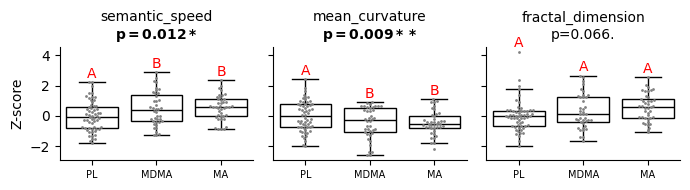

In [40]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your list of variables
variable_list = ['semantic_speed',
                 'mean_curvature',
                 'fractal_dimension'
                ]


# Set the desired layout for subplots
n_vars = len(variable_list)
ncols = n_vars  # adjust this as needed
nrows = 1#math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(7, 2), sharey=True)
if nrows > 1:
    axes = axes.flatten()
else:
    axes = np.array(axes).flatten()

# Define significance threshold
threshold = 0.05
# Define the span used in your analyses (here we assume 40)
current_span = 40

# Loop over the variable list and create each subplot
for i, var in enumerate(variable_list):
    # Process data for the current variable
    df = create_small_talk_data(var)
    
    # Create a hollow boxplot (no fill) of the z_score grouped by Drug,
    # then overlay a beeswarm plot.
    sns.boxplot(x='Drug', y='z_score', data=df, ax=axes[i],
                color="white",
                boxprops={'facecolor':'none', 'edgecolor':'black'},
                whiskerprops={'color':'black'},
                capprops={'color':'black'},
                medianprops={'color':'black'},
                showfliers=False)
    sns.swarmplot(x='Drug', y='z_score', data=df, ax=axes[i], color='gray', size=2)
    
    axes[i].set_xlabel("")
    axes[i].set_ylabel('Z-score')
    
    # Get the corresponding row from small_p_df for the current span and variable.
    # (Assumes small_p_df is available in the workspace.)
    sp_row = small_p_df[(small_p_df['span'] == current_span) & (small_p_df['variable'] == var)]
    if not sp_row.empty:
        sp_row = sp_row.iloc[0]
        anova_p = sp_row['anova_p_value']
        p_PL_vs_MDMA = sp_row['tukey_PL_vs_MDMA']
        p_PL_vs_MA = sp_row['tukey_PL_vs_MA']
        p_MDMA_vs_MA = sp_row['tukey_MDMAvsMA']
        
        if (p_PL_vs_MDMA < threshold) and (p_PL_vs_MA < threshold) and (p_MDMA_vs_MA < threshold):
            # All comparisons significant: all groups are different.
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'C'}
        elif (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA < threshold) and (p_MDMA_vs_MA < threshold):
            # PL and MDMA are not different, but both differ from MA.
            letters = {'PL': 'A', 'MDMA': 'A', 'MA': 'B'}
        elif (p_PL_vs_MA >= threshold) and (p_PL_vs_MDMA < threshold) and (p_MDMA_vs_MA < threshold):
            # PL and MA are not different, MDMA is different.
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'A'}
        elif (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA < threshold) and (p_PL_vs_MA < threshold):
            # MDMA and MA are not different, PL is different.
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'B'}
        elif (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA < threshold):
            # MDMA and MA are not different, PL is different.
            letters = {'PL': 'A', 'MDMA': 'AB', 'MA': 'B'}
        elif (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA < threshold):
            # MDMA and MA are not different (both non-significant) while PL is significantly different from them
            letters = {'PL': 'A', 'MDMA': 'AB', 'MA': 'B'}
        elif (p_PL_vs_MA >= threshold) and (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA < threshold):
            # PL and MA are similar while MDMA differs from both
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'A'}
        elif (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA >= threshold) and (p_MDMA_vs_MA < threshold):
            # MDMA and MA are similar while PL is different (alternate coding)
            letters = {'PL': 'B', 'MDMA': 'A', 'MA': 'A'}
        else:
            # Otherwise, if two or more comparisons are non-significant, assign all groups the same letter.
            letters = {'PL': 'A', 'MDMA': 'A', 'MA': 'A'}
    else:
        # If no row is found, leave letters blank.
        letters = {'PL': '', 'MDMA': '', 'MA': ''}
        anova_p = None

    # Determine y-range for positioning text annotations.
    y_min = df['z_score'].min()
    y_max = df['z_score'].max()
    y_range = y_max - y_min

    ax = axes[i]
    stars=get_p_code(anova_p)
    p_str = f"p={anova_p:.3f}{stars}"
    p_str_bold = r"$\bf{" + p_str + "}$"
    if anova_p<0.05:
        ax.set_title(f'{var}\n{p_str_bold}', fontsize=10)
    else:
        ax.set_title(f'{var}\n{p_str}', fontsize=10)
    # Set labels
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=10)

 #   ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Annotate letters above each box. Here we assume the x positions for the 3 groups are 0, 1, and 2.
    for j, group in enumerate(['PL', 'MDMA', 'MA']):
        group_data = df[df['Drug'] == group]
        if not group_data.empty:
            group_y_max = group_data['z_score'].max()
            ax.text(j, group_y_max + 0.02*y_range, letters[group],
                    ha='center', va='bottom', fontsize=10, color='red')
            
# Remove any unused subplots if n_vars does not exactly fill the grid
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()



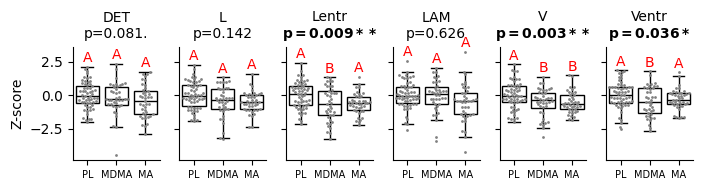

In [46]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your list of variables
variable_list = ['DET','L','Lentr','LAM','V','Ventr']


# Set the desired layout for subplots
n_vars = len(variable_list)
ncols = n_vars  # adjust this as needed
nrows = 1#math.ceil(n_vars / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(7, 2), sharey=True)
if nrows > 1:
    axes = axes.flatten()
else:
    axes = np.array(axes).flatten()

# Define significance threshold
threshold = 0.05
# Define the span used in your analyses (here we assume 40)
current_span = 40

# Loop over the variable list and create each subplot
for i, var in enumerate(variable_list):
    # Process data for the current variable
    df = create_small_talk_data(var)
    
    # Create a hollow boxplot (no fill) of the z_score grouped by Drug,
    # then overlay a beeswarm plot.
    sns.boxplot(x='Drug', y='z_score', data=df, ax=axes[i],
                color="white",
                boxprops={'facecolor':'none', 'edgecolor':'black'},
                whiskerprops={'color':'black'},
                capprops={'color':'black'},
                medianprops={'color':'black'},
                showfliers=False)
    sns.swarmplot(x='Drug', y='z_score', data=df, ax=axes[i], color='gray', size=2)
    
    axes[i].set_xlabel("")
    axes[i].set_ylabel('Z-score')
    
    # Get the corresponding row from small_p_df for the current span and variable.
    # (Assumes small_p_df is available in the workspace.)
    sp_row = small_p_df[(small_p_df['span'] == current_span) & (small_p_df['variable'] == var)]
    if not sp_row.empty:
        sp_row = sp_row.iloc[0]
        anova_p = sp_row['anova_p_value']
        p_PL_vs_MDMA = sp_row['tukey_PL_vs_MDMA']
        p_PL_vs_MA = sp_row['tukey_PL_vs_MA']
        p_MDMA_vs_MA = sp_row['tukey_MDMAvsMA']
        
        if (p_PL_vs_MDMA < threshold) and (p_PL_vs_MA < threshold) and (p_MDMA_vs_MA < threshold):
            # All comparisons significant: all groups are different.
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'C'}
        elif (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA < threshold) and (p_MDMA_vs_MA < threshold):
            # PL and MDMA are not different, but both differ from MA.
            letters = {'PL': 'A', 'MDMA': 'A', 'MA': 'B'}
        elif (p_PL_vs_MA >= threshold) and (p_PL_vs_MDMA < threshold) and (p_MDMA_vs_MA < threshold):
            # PL and MA are not different, MDMA is different.
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'A'}
        elif (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA < threshold) and (p_PL_vs_MA < threshold):
            # MDMA and MA are not different, PL is different.
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'B'}
        elif (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA < threshold):
            # MDMA and MA are not different, PL is different.
            letters = {'PL': 'A', 'MDMA': 'AB', 'MA': 'B'}
        elif (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA < threshold):
            # MDMA and MA are not different (both non-significant) while PL is significantly different from them
            letters = {'PL': 'A', 'MDMA': 'AB', 'MA': 'B'}
        elif (p_PL_vs_MA >= threshold) and (p_MDMA_vs_MA >= threshold) and (p_PL_vs_MDMA < threshold):
            # PL and MA are similar while MDMA differs from both
            letters = {'PL': 'A', 'MDMA': 'B', 'MA': 'A'}
        elif (p_PL_vs_MDMA >= threshold) and (p_PL_vs_MA >= threshold) and (p_MDMA_vs_MA < threshold):
            # MDMA and MA are similar while PL is different (alternate coding)
            letters = {'PL': 'B', 'MDMA': 'A', 'MA': 'A'}
        else:
            # Otherwise, if two or more comparisons are non-significant, assign all groups the same letter.
            letters = {'PL': 'A', 'MDMA': 'A', 'MA': 'A'}
    else:
        # If no row is found, leave letters blank.
        letters = {'PL': '', 'MDMA': '', 'MA': ''}
        anova_p = None

    # Determine y-range for positioning text annotations.
    y_min = df['z_score'].min()
    y_max = df['z_score'].max()
    y_range = y_max - y_min

    ax = axes[i]
    stars=get_p_code(anova_p)
    p_str = f"p={anova_p:.3f}{stars}"
    p_str_bold = r"$\bf{" + p_str + "}$"
    if anova_p<0.05:
        ax.set_title(f'{var}\n{p_str_bold}', fontsize=10)
    else:
        ax.set_title(f'{var}\n{p_str}', fontsize=10)
    # Set labels
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Annotate letters above each box. Here we assume the x positions for the 3 groups are 0, 1, and 2.
    for j, group in enumerate(['PL', 'MDMA', 'MA']):
        group_data = df[df['Drug'] == group]
        if not group_data.empty:
            group_y_max = group_data['z_score'].max()
            ax.text(j, group_y_max + 0.02*y_range, letters[group],
                    ha='center', va='bottom', fontsize=10, color='red')
            
# Remove any unused subplots if n_vars does not exactly fill the grid
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()


In [28]:
p_PL_vs_MA

0.0333222183208695

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure span is sorted for plotting consistency
small_p_df = small_p_df.sort_values(by='span')

# Create pivot tables
effect_matrix = small_p_df.pivot(index='span', columns='variable', values='e_PL_vs_MA')
pval_matrix = small_p_df.pivot(index='span', columns='variable', values='tukey_PL_vs_MA')

# Create annotation matrix: sign (+/-) + significance (*)
def annotate_cell(effect, pval):
    if pd.isna(effect) or pd.isna(pval):
        return ''
    sign = '+' if effect > 0 else '-'
    if pval < 0.001:
        stars = '***'
    elif pval < 0.01:
        stars = '**'
    elif pval < 0.05:
        stars = '*'
    elif pval < 0.1:
        stars = '.'
    else:
        stars = ''
    return f"{sign}{stars}"

annotations = effect_matrix.copy()
for i in effect_matrix.index:
    for j in effect_matrix.columns:
        annotations.loc[i, j] = annotate_cell(effect_matrix.loc[i, j], pval_matrix.loc[i, j])

# Convert effect_matrix to float to avoid issues in heatmap
effect_matrix = effect_matrix.astype(float)

# --- Your existing heatmap setup ---
plt.figure(figsize=(7, 3))
ax = sns.heatmap(effect_matrix, 
                 annot=annotations, 
                 fmt='', 
                 cmap='magma', 
                 cbar_kws={'label': 'Effect Size (e_PL_vs_MA)'}, 
                 linewidths=0.5, 
                 linecolor='gray', 
                 square=True)

# --- Get column labels and add significance markers ---
col_labels = effect_matrix.columns.tolist()
overall_sig=pd.Series(list(small_p_df2[['tukey_PL_vs_MA']]['tukey_PL_vs_MA']), index=col_labels)

def get_sig_code(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ''

# Apply significance codes
sig_labels = [f"{get_sig_code(overall_sig[col])} {col}" for col in col_labels]

# Set new x-axis tick labels with significance
ax.set_xticklabels(sig_labels, rotation=45, ha='right')

# --- Final touches ---
plt.title('Effect Sizes (e_PL_vs_MDMA) by Variable and Span')
plt.ylabel('Span')
plt.xlabel('Variable')
plt.tight_layout()
plt.show()



In [19]:
dir_save_p='/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/stats_results/'
# Save the collected p-values to a CSV file
p_dat=pd.read_csv(dir_save_p+"SER_monologs_p_values.csv")

In [73]:
drug_order=pd.read_csv('/home/ll16598/Documents/POSTDOC/Audio data for all drug studies-selected/SER2/Drug order.csv')
drug_order['Participant']=drug_order['Subject'].str[-3:]
drug_order['Participant']=drug_order['Participant'].astype(int)
csv_file = f"{working_dir}SER_monologs_{span}_mean_50_window_TDA_results.csv"
df = pd.read_csv(csv_file)
df = df.drop(columns=['Drug'])
df['Session']=list(df.Session.str[-1])
df['Session']=df['Session'].astype(int)
df = pd.merge(df, drug_order[['Session', 'Participant', 'Drug']], 
              on=['Session', 'Participant'], 
              how='left')

In [77]:
df.to_csv('/home/ll16598/Documents/POSTDOC/Audio data for all drug studies-selected/SER2/mono_drug_order.csv')

/tmp/ipykernel_8848/1312682441.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma')


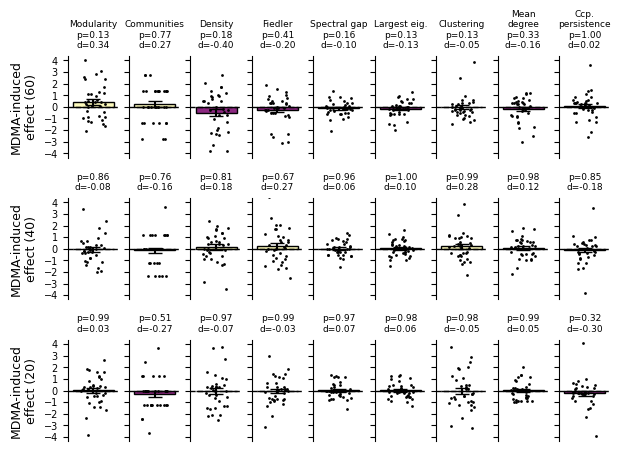

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
dir_save_p='/home/ll16598/Documents/POSTDOC/PSYCH_SEMANTICS/stats_results/'
# Save the collected p-values to a CSV file
p_dat=pd.read_csv(dir_save_p+"SER_monologs_p_values.csv")
def cohen_d(x, y):
    # Calculate the means
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Calculate the pooled standard deviation
    pooled_std = np.sqrt(((np.std(x, ddof=1) ** 2) + (np.std(y, ddof=1) ** 2)) / 2)
    
    # Calculate Cohen's d
    d = (mean_x - mean_y) / pooled_std
    return d
def z_norm(df, var):
    # Add 1 to the specified column
    df[var] = df[var] + 1

    # Subset rows where 'Drug' is placebo (0.00) and filter out missing values in the column
    df_placebo = df[(df['Drug'] == 0.00) & (df[var].notna())]
    
    # Compute the mean and standard deviation for the placebo group
    mean_placebo = df_placebo[var].mean()
    std_placebo = df_placebo[var].std()
    
    # Center the variable and compute the z-score
    df['centered_var'] = df[var] - mean_placebo
    df['z_score'] = df['centered_var'] / std_placebo
    
    return df

# Define working directory and list of variables
working_dir = '/mnt/onetouch/TDA/TDA_output/'
variable_list = [
    'modularity_louvain',
    'num_comms',
    'density',

    'fiedler_value',
    'spectral_gap',
    'largest_laplacian_eigenvalue',
    'clustering_coefficient',
    'mean_degree',
#    'mean_trength',#,
 #   'max_degree'
    'mean_persistence_dim0'
]

variable_names = [
    'Modularity',
    'Communities',
    'Density',

    'Fiedler',
    'Spectral gap',
    'Largest eig.',
    'Clustering',
    'Mean\ndegree',
  #  'Mean\nstrength',
 #   'Max\ndegree'
    'Ccp.\npersistence'
]
spans = [60, 40, 20]  # You can add more spans if needed
cmap = cm.get_cmap('magma')
# Set up the grid of subplots: one row per span, one column per variable.
n_rows = len(spans)
n_cols = len(variable_list)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7, 5), sharey=True)
axes = axes.flatten()  # flatten to simplify indexing

# Loop over each span and variable to create the plots
for i, span in enumerate(spans):
    # Load the CSV file for the current span
    csv_file = f"{working_dir}SER_monologs_{span}_mean_50_window_TDA_results.csv"
    df = pd.read_csv(csv_file)
    df = df.drop(columns=['Drug'])
    df['Session']=list(df.Session.str[-1])
    df['Session']=df['Session'].astype(int)
    df = pd.merge(df, drug_order[['Session', 'Participant', 'Drug']], 
                  on=['Session', 'Participant'], 
                  how='left')
    for j, var in enumerate(variable_list):
        # Work on a copy so that processing one variable doesn't affect others
        df_z = z_norm(df.copy(), var)
        
        # Subset the placebo (Drug==0.00) and treatment (Drug==1.5) groups,
        # keeping only the Participant and computed z_score columns.
        df_placebo = df_z[df_z['Drug'] == 0.00][['Participant', 'z_score']]
        df_treatment = df_z[df_z['Drug'] == 1.5][['Participant', 'z_score']]
        
        # Rename columns for clarity
        df_placebo = df_placebo.rename(columns={'z_score': 'z_score_0'})
        df_treatment = df_treatment.rename(columns={'z_score': 'z_score_1'})
        
        group0 = df_z.loc[df_z['Drug'] == 0.00, 'z_score']
        group1 = df_z.loc[df_z['Drug'] == 1.5, 'z_score']
    
        d = 0-cohen_d(group0, group1)
        # Merge the two groups on Participant (i.e. matched pairs)
        df_merged = pd.merge(df_placebo, df_treatment, on='Participant')
        
        # Compute the difference for each participant (treatment minus placebo)
        df_merged['diff'] = df_merged['z_score_1'] - df_merged['z_score_0']
        
        # Calculate the mean difference and standard error for the barplot
        mean_diff = df_merged['diff'].mean()
        sem_diff = df_merged['diff'].sem()
        if mean_diff >= 0:
            bar_color = cmap(0.99)  # light end of the palette
        else:
            bar_color = cmap(0.4)  # dark end of the palette

        
        # Get the axis for the current subplot
        ax = axes[i*n_cols + j]
        
        # Plot a bar at x=0 with the mean effect and error bar (caps added)
        ax.bar(0, mean_diff, yerr=sem_diff, color=bar_color, edgecolor='black', capsize=5)
        
        # Overlay the individual data points using a stripplot with jitter
        sns.stripplot(x=[0]*len(df_merged['diff']), y=df_merged['diff'], ax=ax,
                      color='black', size=2, jitter=0.25)
        
        # Remove x-axis ticks and labels (only one bar)
        ax.set_xticks([])
        ax.set_xlabel('')
        
        # Draw a horizontal dashed line at y=0 to center the plot
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        
        # Set the title as the variable name (only for the top row)

        p_val_row = p_dat[(p_dat['span'] == span) & (p_dat['variable'] == var)]
        if not p_val_row.empty:
            p_val = p_val_row['tukey_PL_vs_1.5'].values[0]
            p_code = get_p_code(p_val)
        else:
            p_val = np.nan
            p_code = ''

        # Choose formatting: if p_val > 0.1, display to 2 significant places; otherwise, 3 decimal places.
        if p_val > 0.1:
            p_str = f"p={p_val:.2f}{p_code}"
        else:
            p_str = f"p={p_val:.3f}{p_code}"

        # Bold only the p-value line if p < 0.05
        if p_val < 0.1:
            p_str = r"$\bf{" + p_str + "}$"

        # Build the title string: include the variable name in the top row
        if i == 0:
            title_str = f"{variable_names[j]}\n" + p_str+f"\nd={d:.2f}"
        else:
            title_str = p_str+f"\nd={d:.2f}"

        ax.set_title(title_str, fontsize=6.5)

        # Enforce symmetric y-limits centered at 0
        ax.set_yticks(np.arange(-4,4.01,1))
        ax.tick_params(axis='y', labelsize=7)
        ymin, ymax = ax.get_ylim()
        bound = max(abs(ymin), abs(ymax))
        ax.set_ylim(-bound, bound)
        ax.set_ylabel(f'MDMA-induced\neffect ({span})',fontsize=9)

        # Remove the top and right spines to get a cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

# Adjust subplot spacing: reduce horizontal spacing between plots
plt.subplots_adjust(wspace=0.2, hspace=0.4)
if save:
    plt.savefig(dir_save_figs+'monolog_TDA.png', dpi=800, bbox_inches='tight')

#plt.tight_layout()
#plt.show()


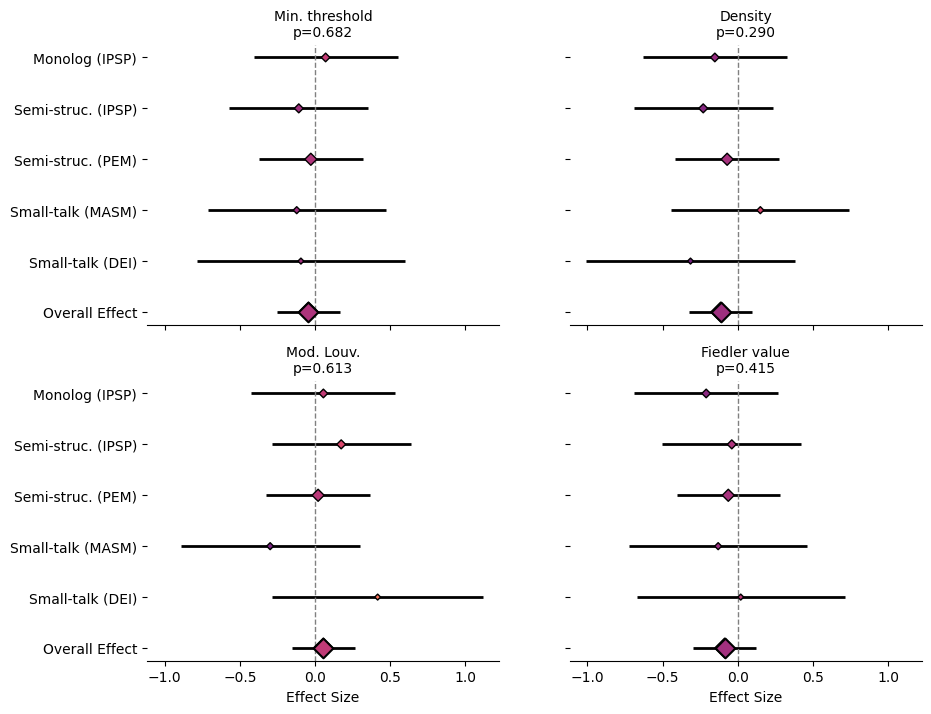

In [27]:
# Example usage:

span=3
props=['rt','density','modularity_louvain', 'fiedler_value']
titles=['Min. threshold','Density',
       'Mod. Louv.','Fiedler value']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flat  
for i, (prop, ax) in enumerate(zip(props, axes)):
    title=titles[i]
    data = pd.read_csv(meta_dir + f'{prop}_{span}utt_forest_plot_data.csv')  # Load dataset
    
    data["Study"] = data["Study"].replace({
    "SER_monologs": "Monolog (IPSP)",
    "SER_IPSP": "Semi-struc. (IPSP)",
    "PEM_df": "Semi-struc. (PEM)",
    "MASM": "Small-talk (MASM)",
    "cleaned_DEI": "Small-talk (DEI)",
    "Overall (Random-Effects)": "Overall Effect"
})
    if i in [0,1]:
        show_x=False
    else:
        show_x=True
    plot_forest(ax, data, title, show_X=show_x)  # Plot on respective panel

plt.show()